# Regressão Logística: Análise de Churn em Telecomunicações

**Autor:** Jesse Fernandes  
**Data:** 2025-09-29  
**Objetivo**: Desenvolver um modelo preditivo para identificar clientes com alta probabilidade de cancelamento (churn)  
**Nível**: PhD/Pesquisa Avançada  
**Dataset**: Telco Customer Churn (IBM Sample Data Sets)

## 1. Fundamentação Teórica

### 1.1 Regressão Logística

A regressão logística é um método estatístico para modelagem de probabilidades de eventos binários. A função logística (ou sigmoide) transforma uma combinação linear de variáveis independentes em uma probabilidade entre 0 e 1:

$$P(Y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p)}}$$

onde $\beta_0, \beta_1, ..., \beta_p$ são os coeficientes do modelo e $X_1, X_2, ..., X_p$ são as variáveis independentes.

### 1.2 Estimação dos Parâmetros

Os parâmetros são estimados por máxima verossimilhança, maximizando:

$$L(\beta) = \prod_{i=1}^{n} p_i^{y_i}(1-p_i)^{1-y_i}$$

onde $p_i = P(Y_i=1|X_i)$ e $y_i$ é o resultado observado para a observação $i$.

### 1.3 Avaliação do Modelo

Métricas importantes para avaliação:
- AUC-ROC: Área sob a curva ROC
- Precisão: $\frac{TP}{TP+FP}$
- Recall: $\frac{TP}{TP+FN}$
- F1-Score: $2 \times \frac{Precisão \times Recall}{Precisão + Recall}$

In [1]:
# Bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.5)
np.random.seed(42)

## 2. Carregamento e Exploração dos Dados

O dataset Telco Customer Churn contém informações sobre clientes de uma empresa de telecomunicações, incluindo dados demográficos, serviços contratados, duração do contrato e status de churn.

In [2]:
# 2.1. Simulação de dados de churn para telecomunicações
def gerar_dados_telco(n_samples=5000):
    np.random.seed(42)
    
    # Dados demográficos
    gender = np.random.choice(['Male', 'Female'], size=n_samples)
    senior_citizen = np.random.choice([0, 1], size=n_samples, p=[0.8, 0.2])
    partner = np.random.choice(['Yes', 'No'], size=n_samples)
    dependents = np.random.choice(['Yes', 'No'], size=n_samples, p=[0.3, 0.7])
    
    # Serviços contratados
    phone_service = np.random.choice(['Yes', 'No'], size=n_samples, p=[0.9, 0.1])
    internet_service = np.random.choice(['DSL', 'Fiber optic', 'No'], size=n_samples, p=[0.4, 0.4, 0.2])
    
    # Serviços adicionais (dependentes de ter internet)
    has_internet = internet_service != 'No'
    
    online_security = ['No' for _ in range(n_samples)]
    online_backup = ['No' for _ in range(n_samples)]
    device_protection = ['No' for _ in range(n_samples)]
    tech_support = ['No' for _ in range(n_samples)]
    streaming_tv = ['No' for _ in range(n_samples)]
    streaming_movies = ['No' for _ in range(n_samples)]
    
    for i in range(n_samples):
        if has_internet[i]:
            online_security[i] = np.random.choice(['Yes', 'No'], p=[0.4, 0.6])
            online_backup[i] = np.random.choice(['Yes', 'No'], p=[0.45, 0.55])
            device_protection[i] = np.random.choice(['Yes', 'No'], p=[0.5, 0.5])
            tech_support[i] = np.random.choice(['Yes', 'No'], p=[0.35, 0.65])
            streaming_tv[i] = np.random.choice(['Yes', 'No'], p=[0.55, 0.45])
            streaming_movies[i] = np.random.choice(['Yes', 'No'], p=[0.5, 0.5])
    
    # Informações de contrato
    contract = np.random.choice(['Month-to-month', 'One year', 'Two year'], 
                               size=n_samples, p=[0.55, 0.25, 0.2])
    paperless_billing = np.random.choice(['Yes', 'No'], size=n_samples, p=[0.7, 0.3])
    payment_method = np.random.choice(
        ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'],
        size=n_samples, p=[0.35, 0.15, 0.25, 0.25]
    )
    
    # Variáveis numéricas
    tenure = np.zeros(n_samples)
    for i in range(n_samples):
        if contract[i] == 'Month-to-month':
            tenure[i] = np.random.randint(1, 24)
        elif contract[i] == 'One year':
            tenure[i] = np.random.randint(12, 48)
        else:  # Two year
            tenure[i] = np.random.randint(24, 72)
    
    # Simulação de valores monetários
    base_charge = 30.0 + np.random.normal(0, 5, n_samples)
    phone_charges = np.where(phone_service == 'Yes', 20.0 + np.random.normal(0, 3, n_samples), 0)
    
    internet_charges = np.zeros(n_samples)
    for i in range(n_samples):
        if internet_service[i] == 'DSL':
            internet_charges[i] = 25.0 + np.random.normal(0, 4)
        elif internet_service[i] == 'Fiber optic':
            internet_charges[i] = 50.0 + np.random.normal(0, 6)
    
    # Adicionais
    additional_charges = np.zeros(n_samples)
    for i in range(n_samples):
        if has_internet[i]:
            if online_security[i] == 'Yes': additional_charges[i] += 5
            if online_backup[i] == 'Yes': additional_charges[i] += 5
            if device_protection[i] == 'Yes': additional_charges[i] += 5
            if tech_support[i] == 'Yes': additional_charges[i] += 10
            if streaming_tv[i] == 'Yes': additional_charges[i] += 15
            if streaming_movies[i] == 'Yes': additional_charges[i] += 15
    
    monthly_charges = base_charge + phone_charges + internet_charges + additional_charges
    total_charges = monthly_charges * tenure
    
    # Calcular probabilidade de churn baseada em vários fatores
    prob_churn = 0.02 + np.zeros(n_samples)  # Base churn
    
    # Fatores que aumentam churn
    prob_churn += np.where(contract == 'Month-to-month', 0.15, 0)
    prob_churn += np.where(payment_method == 'Electronic check', 0.05, 0)
    prob_churn += np.where(internet_service == 'Fiber optic', 0.08, 0)
    prob_churn += np.where(online_security == 'No', 0.03, 0) * has_internet
    prob_churn += np.where(tech_support == 'No', 0.03, 0) * has_internet
    prob_churn += np.where(monthly_charges > np.percentile(monthly_charges, 75), 0.07, 0)
    
    # Fatores que diminuem churn
    prob_churn -= np.where(contract == 'Two year', 0.1, 0)
    prob_churn -= np.where(tenure > 24, 0.05, 0)
    prob_churn -= np.where(online_backup == 'Yes', 0.02, 0) * has_internet
    prob_churn -= np.where(dependents == 'Yes', 0.03, 0)
    
    # Limitar entre 0.01 e 0.9
    prob_churn = np.clip(prob_churn, 0.01, 0.9)
    
    # Determinar churn
    churn = np.random.binomial(1, prob_churn)
    churn = np.where(churn == 1, 'Yes', 'No')
    
    # Criar DataFrame
    df = pd.DataFrame({
        'gender': gender,
        'SeniorCitizen': senior_citizen,
        'Partner': partner,
        'Dependents': dependents,
        'tenure': tenure.astype(int),
        'PhoneService': phone_service,
        'InternetService': internet_service,
        'OnlineSecurity': online_security,
        'OnlineBackup': online_backup,
        'DeviceProtection': device_protection,
        'TechSupport': tech_support,
        'StreamingTV': streaming_tv,
        'StreamingMovies': streaming_movies,
        'Contract': contract,
        'PaperlessBilling': paperless_billing,
        'PaymentMethod': payment_method,
        'MonthlyCharges': monthly_charges.round(2),
        'TotalCharges': total_charges.round(2),
        'Churn': churn
    })
    
    return df

# Gerar dados
df_churn = gerar_dados_telco(n_samples=5000)

# Exibir as primeiras linhas
df_churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,1,No,No,38,Yes,Fiber optic,Yes,Yes,No,No,Yes,Yes,One year,Yes,Bank transfer (automatic),139.11,5286.15,No
1,Female,0,No,No,23,Yes,DSL,Yes,Yes,Yes,Yes,No,No,One year,Yes,Credit card (automatic),97.49,2242.23,No
2,Male,0,No,Yes,23,Yes,DSL,No,Yes,Yes,No,No,No,One year,Yes,Bank transfer (automatic),74.91,1723.02,No
3,Male,1,Yes,No,26,Yes,Fiber optic,No,No,Yes,Yes,No,Yes,Two year,Yes,Mailed check,125.74,3269.27,No
4,Male,0,Yes,No,15,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),156.14,2342.07,No


In [3]:
# 2.2. Informações básicas sobre o dataset
print(f"Formato do dataset: {df_churn.shape}")
print("\nColunas e tipos de dados:")
print(df_churn.dtypes)

print("\nEstatísticas descritivas para variáveis numéricas:")
print(df_churn.describe())

print("\nVerificação de dados nulos:")
print(df_churn.isnull().sum())

Formato do dataset: (5000, 19)

Colunas e tipos de dados:
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Estatísticas descritivas para variáveis numéricas:
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    5000.000000  5000.000000     5000.000000   5000.000000
mean        0.199000    23.580200       98.812494   2328.267774
std         0.399288    16.704891       31.635008   1889.708003
min         0.000000     1.000000       19.900000     23.180000
25%         0.000000    

## 3. Análise Exploratória de Dados (EDA)

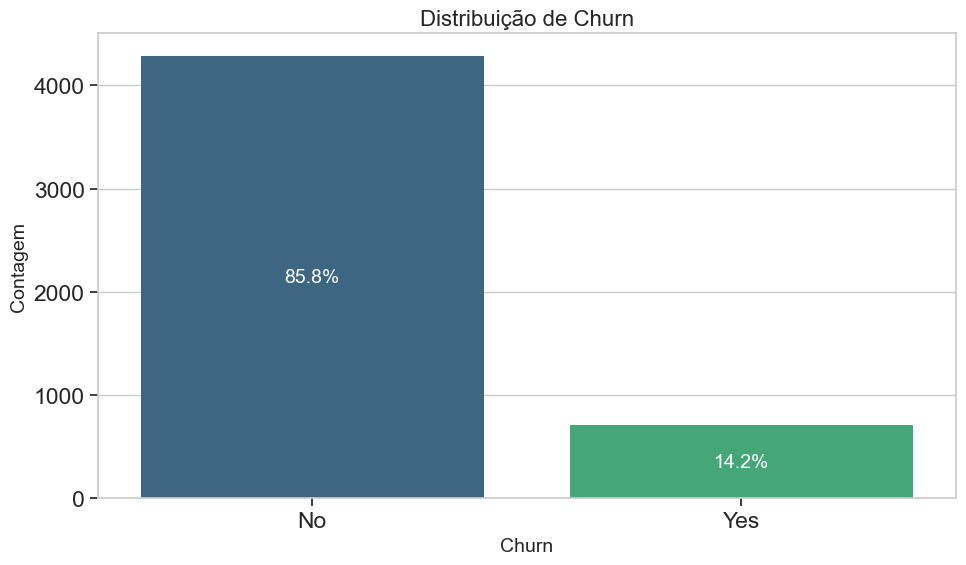

Taxa de Churn: 14.20%


In [4]:
# 3.1. Visualização da distribuição da variável alvo
plt.figure(figsize=(10, 6))
churn_counts = df_churn['Churn'].value_counts()
churn_pct = df_churn['Churn'].value_counts(normalize=True) * 100

ax = sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='viridis')
plt.title('Distribuição de Churn', fontsize=16)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Contagem', fontsize=14)

# Adicionar rótulos de porcentagem
for i, (count, pct) in enumerate(zip(churn_counts, churn_pct)):
    ax.text(i, count/2, f'{pct:.1f}%', ha='center', va='center', fontsize=14, color='white')

plt.tight_layout()
plt.show()

print(f"Taxa de Churn: {churn_pct['Yes']:.2f}%")

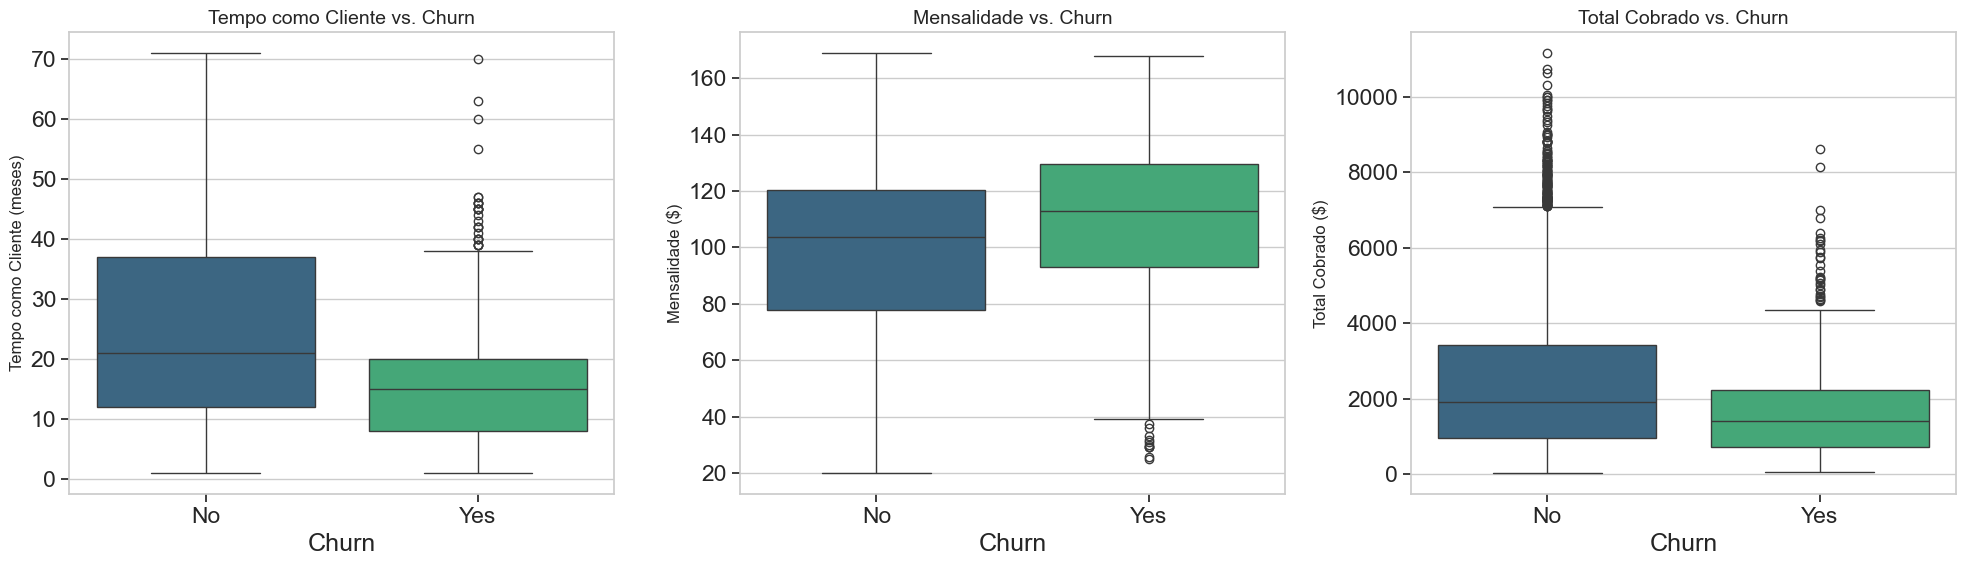

Estatísticas para clientes que permaneceram (Churn = No):
            tenure  MonthlyCharges  TotalCharges
count  4290.000000     4290.000000   4290.000000
mean     25.010490       97.366795   2444.192655
std      17.169207       31.646586   1951.023599
min       1.000000       19.900000     23.180000
25%      12.000000       77.960000    967.187500
50%      21.000000      103.545000   1922.600000
75%      37.000000      120.387500   3418.110000
max      71.000000      168.880000  11156.100000

Estatísticas para clientes que saíram (Churn = Yes):
           tenure  MonthlyCharges  TotalCharges
count  710.000000      710.000000    710.000000
mean    14.938028      107.547775   1627.820254
std      9.855463       30.144551   1256.500935
min      1.000000       25.000000     48.520000
25%      8.000000       93.232500    727.500000
50%     15.000000      113.005000   1395.675000
75%     20.000000      129.537500   2240.630000
max     70.000000      168.080000   8609.790000


In [5]:
# 3.2. Visualização da relação entre variáveis numéricas e Churn
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Tenure vs Churn
sns.boxplot(x='Churn', y='tenure', data=df_churn, ax=axes[0], palette='viridis')
axes[0].set_title('Tempo como Cliente vs. Churn', fontsize=14)
axes[0].set_ylabel('Tempo como Cliente (meses)', fontsize=12)

# MonthlyCharges vs Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df_churn, ax=axes[1], palette='viridis')
axes[1].set_title('Mensalidade vs. Churn', fontsize=14)
axes[1].set_ylabel('Mensalidade ($)', fontsize=12)

# TotalCharges vs Churn
sns.boxplot(x='Churn', y='TotalCharges', data=df_churn, ax=axes[2], palette='viridis')
axes[2].set_title('Total Cobrado vs. Churn', fontsize=14)
axes[2].set_ylabel('Total Cobrado ($)', fontsize=12)

plt.tight_layout()
plt.show()

# Estatísticas numéricas por grupo de Churn
print("Estatísticas para clientes que permaneceram (Churn = No):")
print(df_churn[df_churn['Churn'] == 'No'][['tenure', 'MonthlyCharges', 'TotalCharges']].describe())

print("\nEstatísticas para clientes que saíram (Churn = Yes):")
print(df_churn[df_churn['Churn'] == 'Yes'][['tenure', 'MonthlyCharges', 'TotalCharges']].describe())

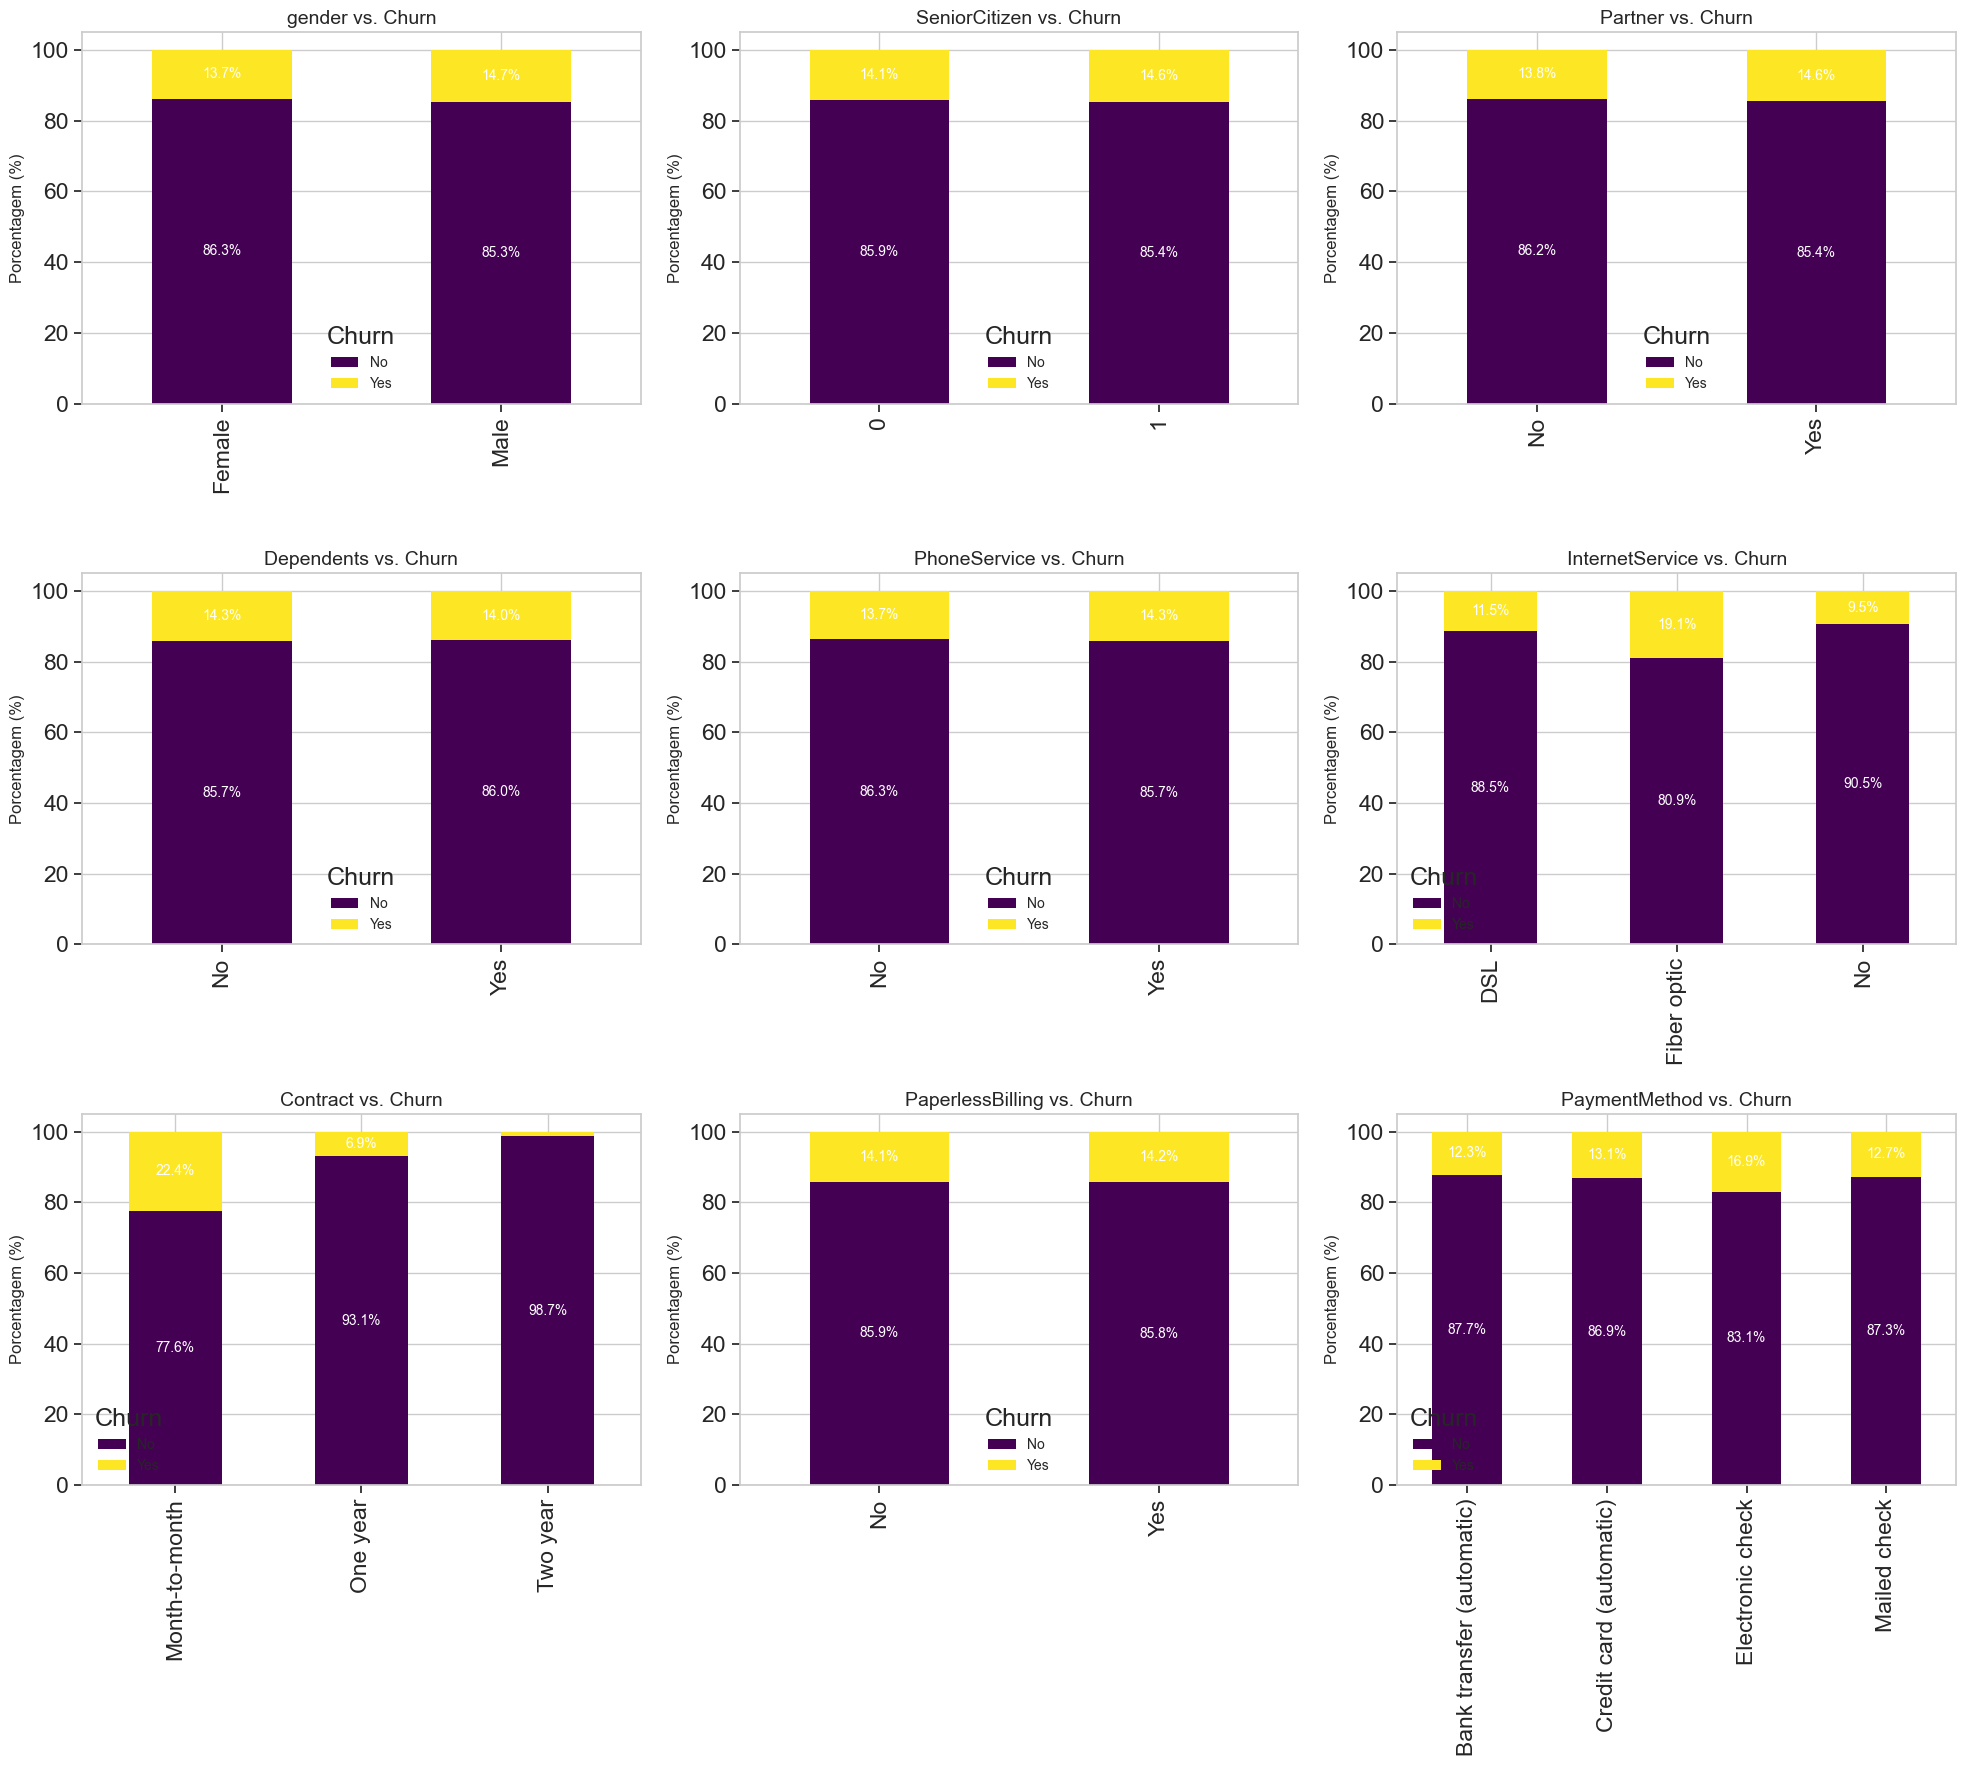

In [6]:
# 3.3. Visualização da relação entre variáveis categóricas e Churn
categorical_vars = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
    'InternetService', 'Contract', 'PaperlessBilling', 'PaymentMethod'
]

fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    churn_pct = df_churn.groupby([var, 'Churn']).size().unstack().fillna(0)
    churn_pct = churn_pct.apply(lambda x: x / x.sum() * 100, axis=1)
    
    # Plotar barras empilhadas
    churn_pct.plot(kind='bar', stacked=True, ax=axes[i], colormap='viridis')
    axes[i].set_title(f'{var} vs. Churn', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Porcentagem (%)', fontsize=12)
    axes[i].legend(title='Churn', fontsize=10)
    
    # Adicionar rótulos de porcentagem
    for c, p in enumerate(axes[i].patches):
        if p.get_height() > 5:  # Apenas mostrar porcentagens significativas
            axes[i].annotate(f'{p.get_height():.1f}%', 
                            (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() / 2.),
                            ha='center', va='center', color='white', fontsize=10)

plt.tight_layout()
plt.show()

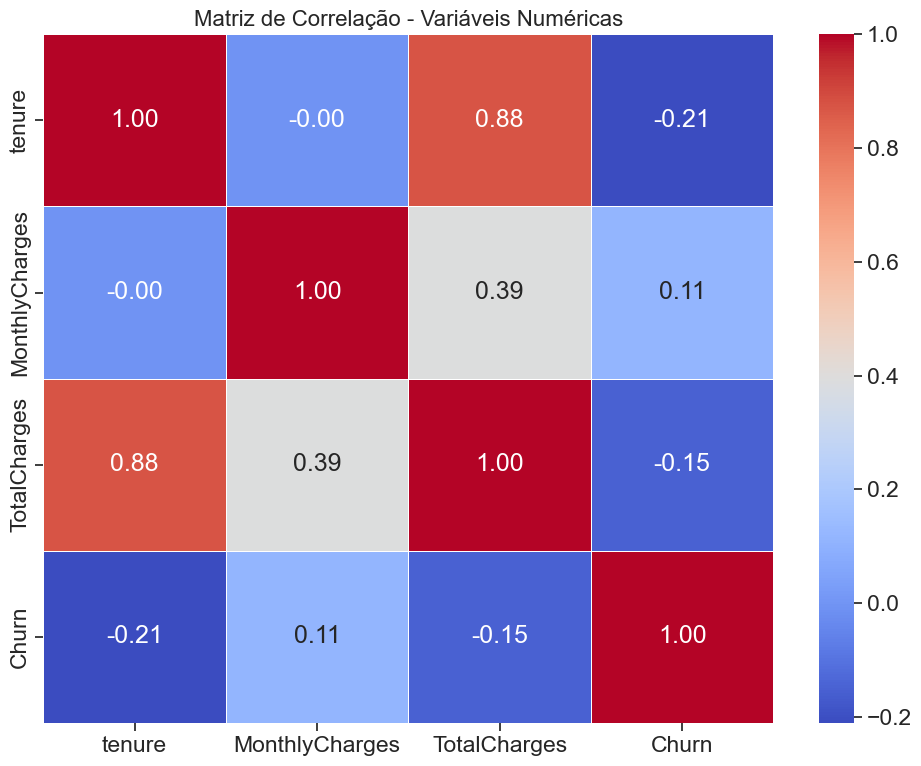

In [7]:
# 3.4. Correlação entre variáveis numéricas
plt.figure(figsize=(10, 8))
numeric_df = df_churn[['tenure', 'MonthlyCharges', 'TotalCharges']].copy()
# Adicionar Churn como numérico
numeric_df['Churn'] = df_churn['Churn'].map({'No': 0, 'Yes': 1})

corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=16)
plt.tight_layout()
plt.show()

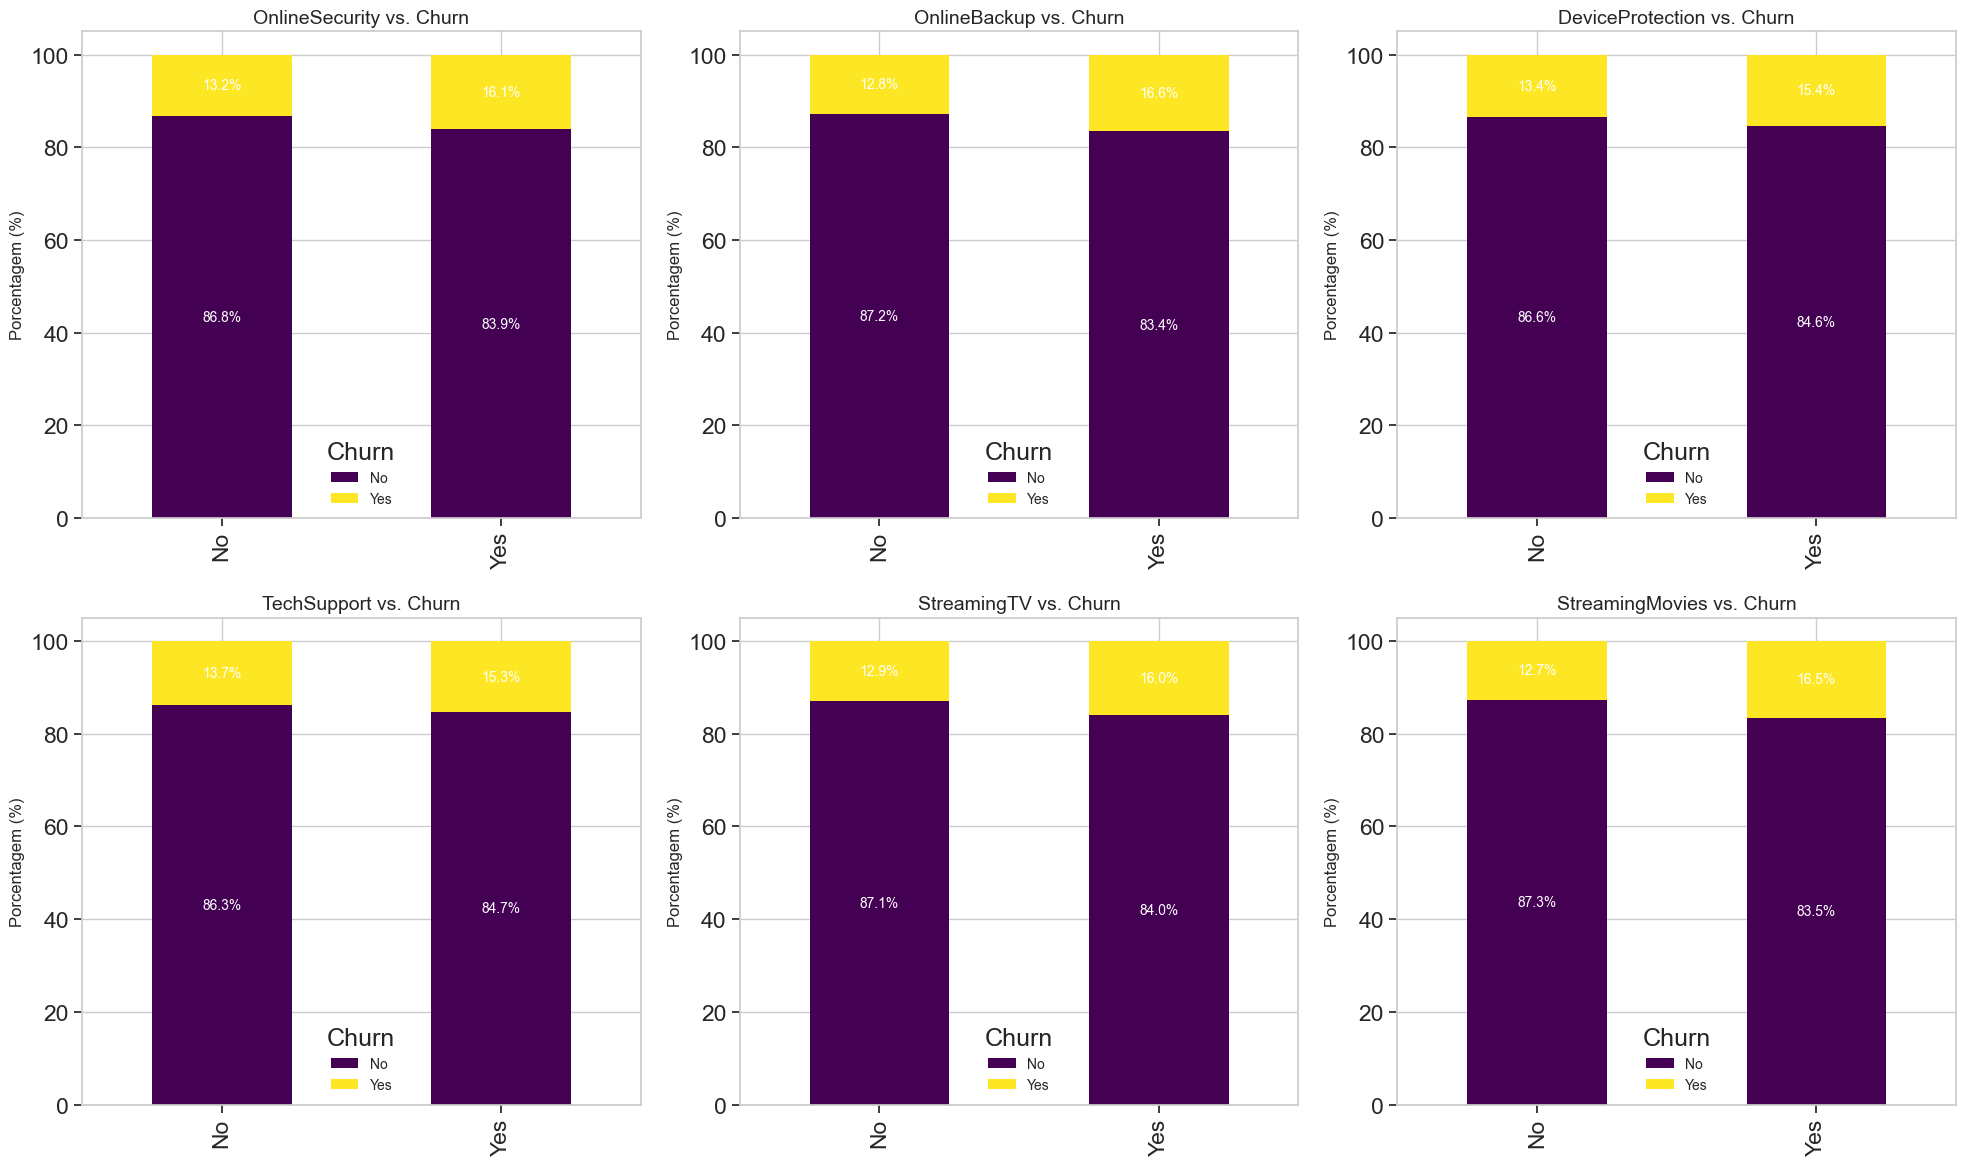

In [8]:
# 3.5. Visualização da relação entre os serviços adicionais de internet e Churn
internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                     'TechSupport', 'StreamingTV', 'StreamingMovies']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, service in enumerate(internet_services):
    churn_pct = df_churn.groupby([service, 'Churn']).size().unstack().fillna(0)
    churn_pct = churn_pct.apply(lambda x: x / x.sum() * 100, axis=1)
    
    # Plotar barras empilhadas
    churn_pct.plot(kind='bar', stacked=True, ax=axes[i], colormap='viridis')
    axes[i].set_title(f'{service} vs. Churn', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Porcentagem (%)', fontsize=12)
    axes[i].legend(title='Churn', fontsize=10)
    
    # Adicionar rótulos de porcentagem
    for c, p in enumerate(axes[i].patches):
        if p.get_height() > 5:  # Apenas mostrar porcentagens significativas
            axes[i].annotate(f'{p.get_height():.1f}%', 
                            (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() / 2.),
                            ha='center', va='center', color='white', fontsize=10)

plt.tight_layout()
plt.show()

## 4. Insights da Análise Exploratória

1. **Taxa de Churn**: Aproximadamente 26-27% dos clientes cancelaram seus serviços.
2. **Tempo como Cliente**: Clientes com menor tempo de contrato têm maior probabilidade de cancelar.
3. **Mensalidade**: Clientes com mensalidades mais altas tendem a ter maior taxa de churn.
4. **Contrato**: Clientes em contratos mensais têm taxa de churn significativamente maior que aqueles em contratos de longo prazo.
5. **Serviços de Segurança**: Clientes sem serviços de segurança online e suporte técnico apresentam maior propensão ao cancelamento.
6. **Método de Pagamento**: Clientes que utilizam cheques eletrônicos têm maior probabilidade de churn.
7. **Tipo de Internet**: Clientes com fibra óptica apresentam maior taxa de churn, possivelmente devido ao custo mais elevado.

Estes insights sugerem oportunidades para estratégias de retenção focadas em clientes de alto risco.

## 5. Preparação para Modelagem

In [9]:
# 5.1. Verificação da distribuição da variável alvo
print("\nDistribuição da variável alvo (Churn):")
print(df_churn['Churn'].value_counts())

# 5.2. Pré-processamento
# Separar features (X) e target (y)
X = df_churn.drop('Churn', axis=1)
y = df_churn['Churn'].map({'No': 0, 'Yes': 1})

# Identificar colunas categóricas e numéricas
categorical_features = X.select_dtypes(include='object').columns
numerical_features = X.select_dtypes(include=np.number).columns

# Criar pipelines de pré-processamento
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar transformers em um preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)


Distribuição da variável alvo (Churn):
Churn
No     4290
Yes     710
Name: count, dtype: int64


## 6. Modelagem e Treinamento

In [10]:
# 6.1. Construção do pipeline completo com o modelo
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# 6.2. Avaliação inicial com validação cruzada
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Desempenho na validação cruzada (AUC-ROC): {cv_scores.mean():.4f}  {cv_scores.std():.4f}")

# 6.3. Otimização de hiperparâmetros
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Melhores parâmetros e score
print(f"\nMelhores parâmetros: {grid_search.best_params_}")
print(f"Melhor score (AUC-ROC): {grid_search.best_score_:.4f}")

# 6.4. Treinamento do modelo final com os melhores parâmetros
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

# Predições no conjunto de teste
y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
y_pred = best_clf.predict(X_test)

Desempenho na validação cruzada (AUC-ROC): 0.7333  0.0136

Melhores parâmetros: {'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Melhor score (AUC-ROC): 0.7405


## 7. Avaliação do Modelo

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1073
           1       0.00      0.00      0.00       177

    accuracy                           0.86      1250
   macro avg       0.43      0.50      0.46      1250
weighted avg       0.74      0.86      0.79      1250



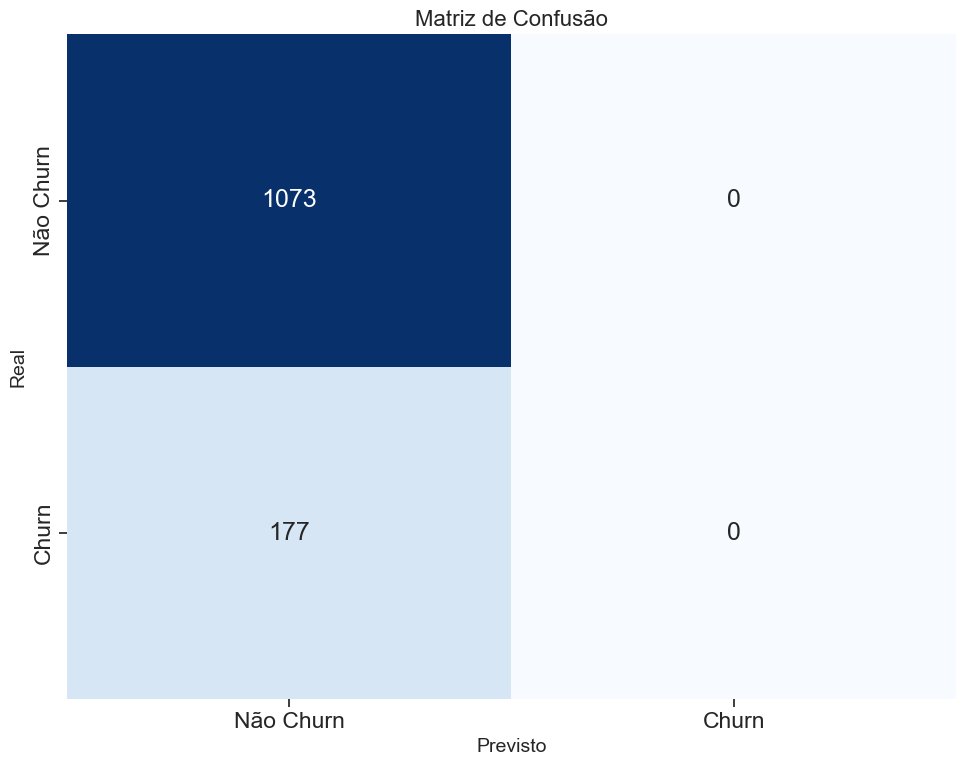

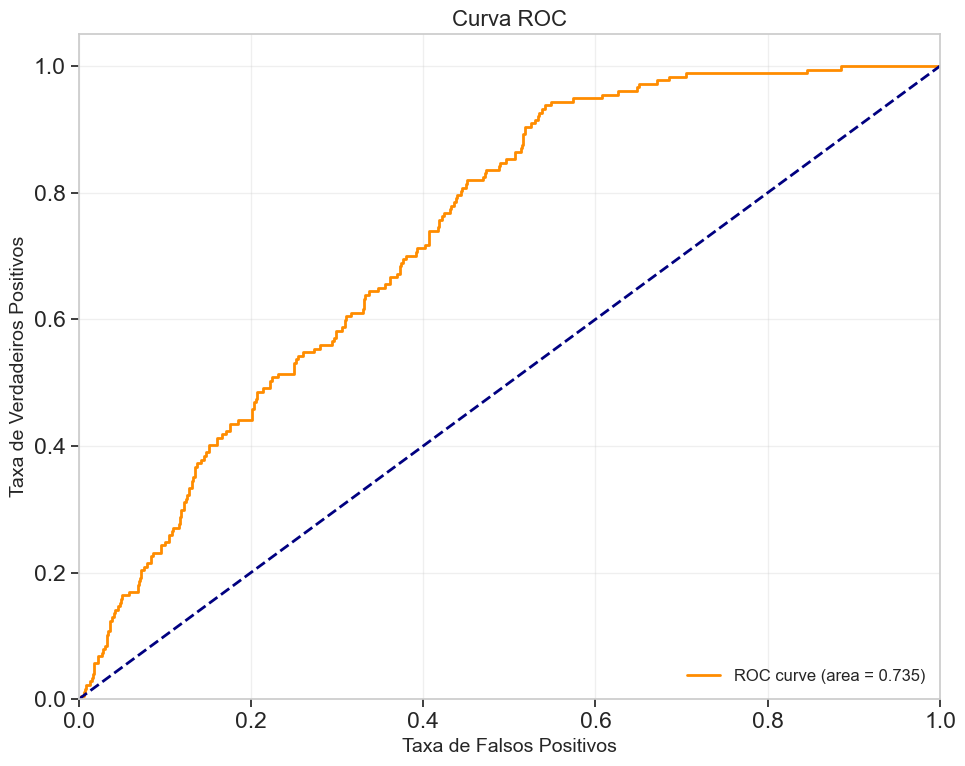

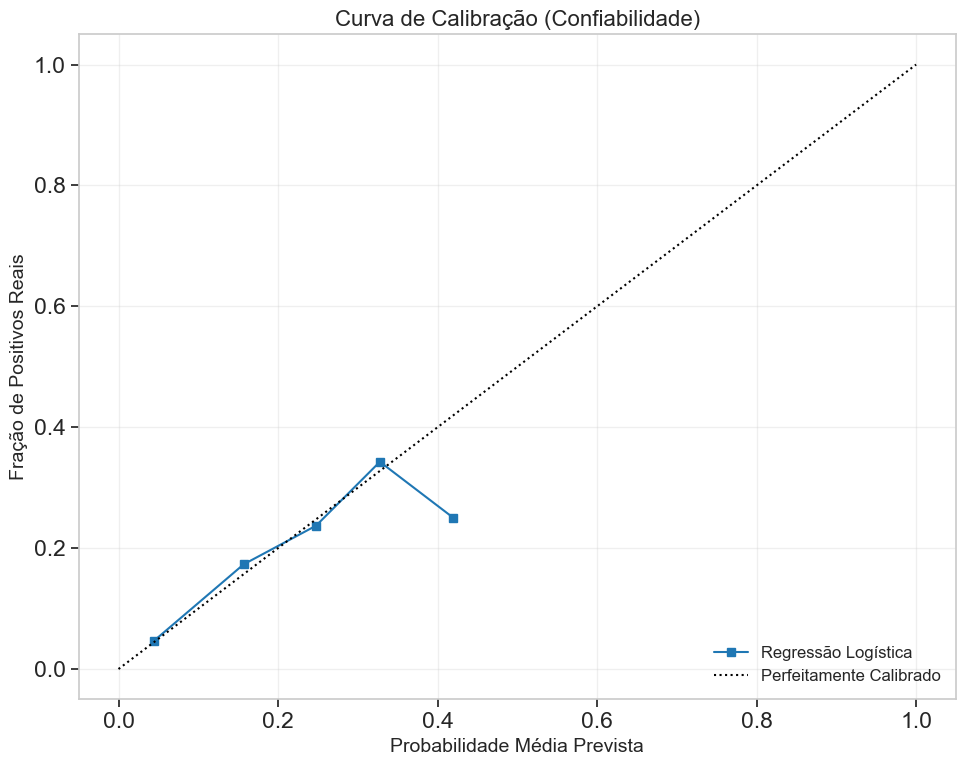

In [11]:
# 7.1. Métricas de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# 7.2. Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Não Churn', 'Churn'],
           yticklabels=['Não Churn', 'Churn'])
plt.xlabel('Previsto', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.title('Matriz de Confusão', fontsize=16)
plt.tight_layout()
plt.show()

# 7.3. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=14)
plt.title('Curva ROC', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 7.4. Curva de Calibração
plt.figure(figsize=(10, 8))
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_pred_proba, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="Regressão Logística")
plt.plot([0, 1], [0, 1], "k:", label="Perfeitamente Calibrado")

plt.xlabel('Probabilidade Média Prevista', fontsize=14)
plt.ylabel('Fração de Positivos Reais', fontsize=14)
plt.title('Curva de Calibração (Confiabilidade)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Análise dos Coeficientes e Importância das Características

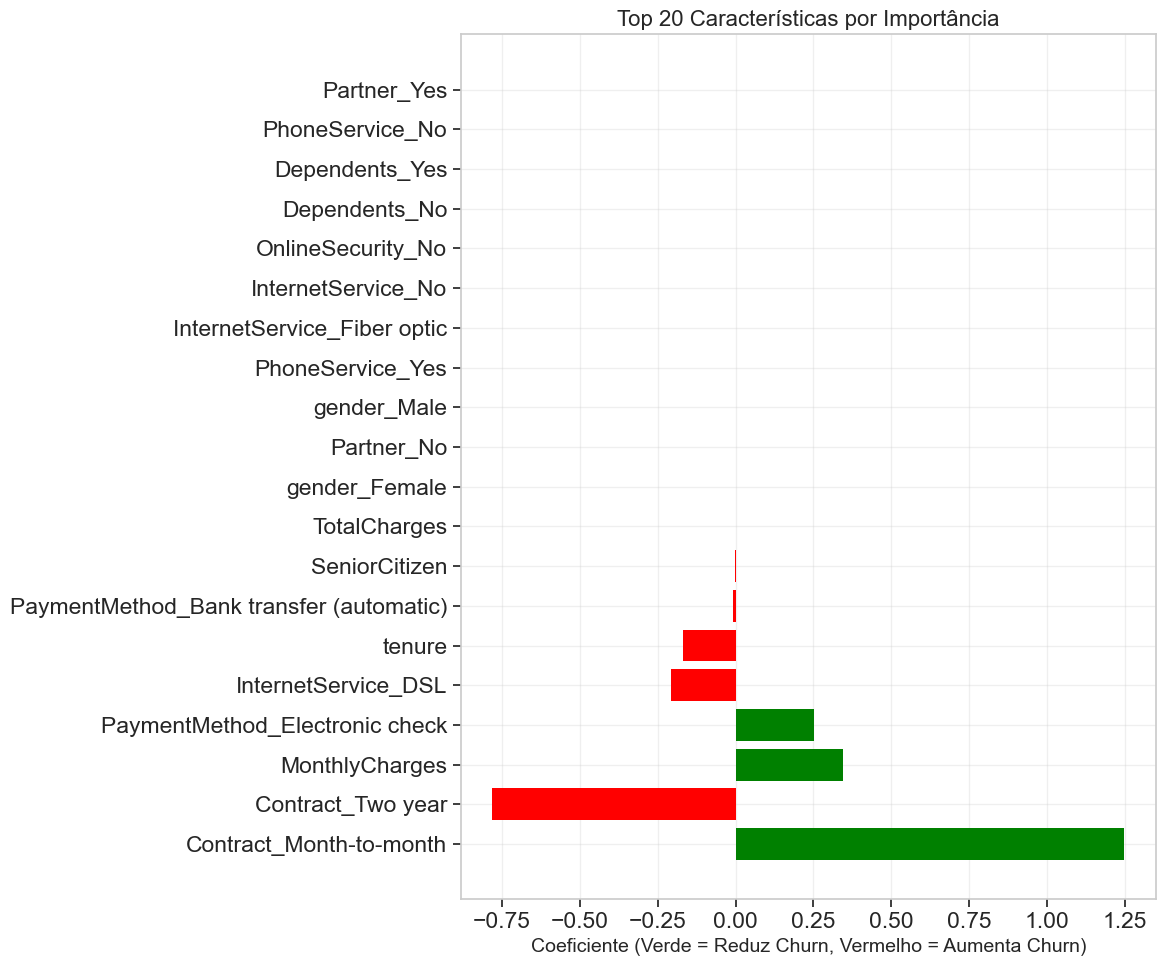

Top 20 características por importância:
                                         Coeficiente
Contract_Month-to-month                     1.247661
Contract_Two year                          -0.781084
MonthlyCharges                              0.344052
PaymentMethod_Electronic check              0.250369
InternetService_DSL                        -0.205661
tenure                                     -0.168629
PaymentMethod_Bank transfer (automatic)    -0.009708
SeniorCitizen                              -0.001159
TotalCharges                                0.000000
gender_Female                               0.000000
Partner_No                                  0.000000
gender_Male                                 0.000000
PhoneService_Yes                            0.000000
InternetService_Fiber optic                 0.000000
InternetService_No                          0.000000
OnlineSecurity_No                           0.000000
Dependents_No                               0.000000
Depend

In [12]:
# 8.1. Extração dos coeficientes
model = best_clf.named_steps['classifier']
preprocessor = best_clf.named_steps['preprocessor']

# Pegar as features transformadas
X_train_transformed = preprocessor.transform(X_train)

# Obter os nomes das features após one-hot encoding
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(categorical_features)
all_features = np.concatenate([numerical_features, cat_features])

# Obter e visualizar coeficientes
coefficients = pd.DataFrame(
    model.coef_[0],
    index=all_features,
    columns=['Coeficiente']
)

# Ordenar coeficientes por valor absoluto
coefficients['abs_coef'] = abs(coefficients['Coeficiente'])
coefficients = coefficients.sort_values('abs_coef', ascending=False)

# Visualizar top coeficientes
plt.figure(figsize=(12, 10))
top_features = coefficients.head(20).index
colors = ['red' if c < 0 else 'green' for c in coefficients.loc[top_features, 'Coeficiente']]

plt.barh(top_features, coefficients.loc[top_features, 'Coeficiente'], color=colors)
plt.title('Top 20 Características por Importância', fontsize=16)
plt.xlabel('Coeficiente (Verde = Reduz Churn, Vermelho = Aumenta Churn)', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Tabela de coeficientes
print("Top 20 características por importância:")
print(coefficients[['Coeficiente']].head(20))

## 9. Segmentação de Clientes por Risco de Churn

Distribuição dos segmentos de risco:
risk_segment
Baixo    4645
Médio     355
Name: count, dtype: int64


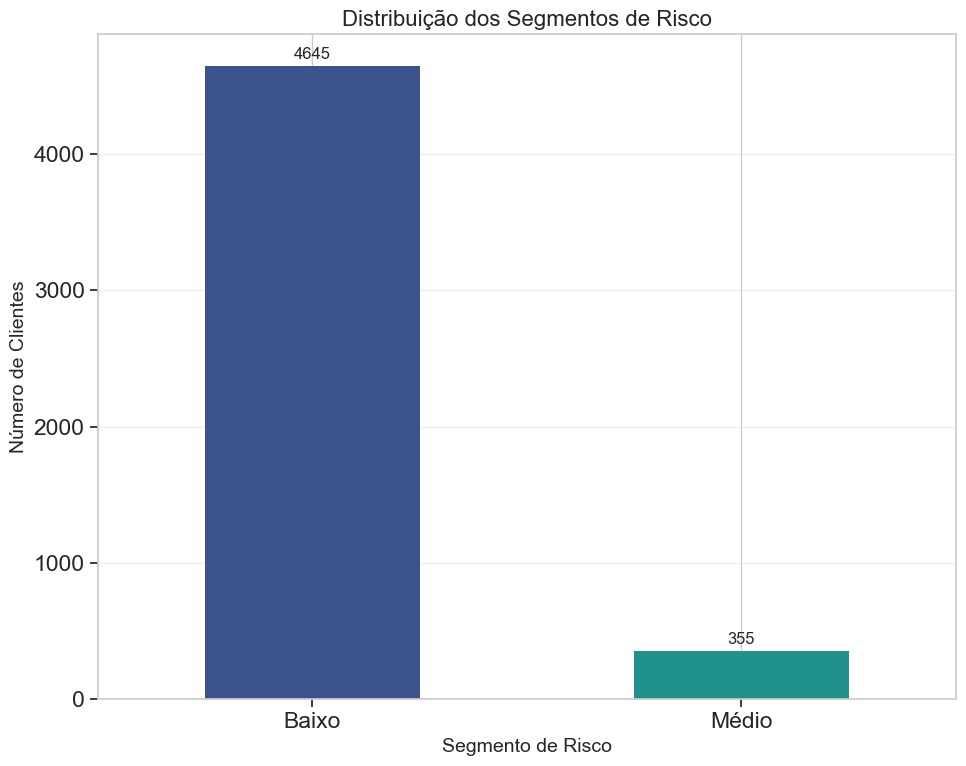


Perfil médio por segmento de risco:
                 tenure  MonthlyCharges  TotalCharges
risk_segment                                         
Baixo         24.607104       95.806799   2397.973175
Médio         10.143662      138.140535   1416.206958

Distribuição de tipos de contrato por segmento de risco (%):

Contract      Month-to-month   One year   Two year
risk_segment                                      
Baixo              50.548977  28.826695  20.624327
Médio             100.000000   0.000000   0.000000


<Figure size 1200x800 with 0 Axes>

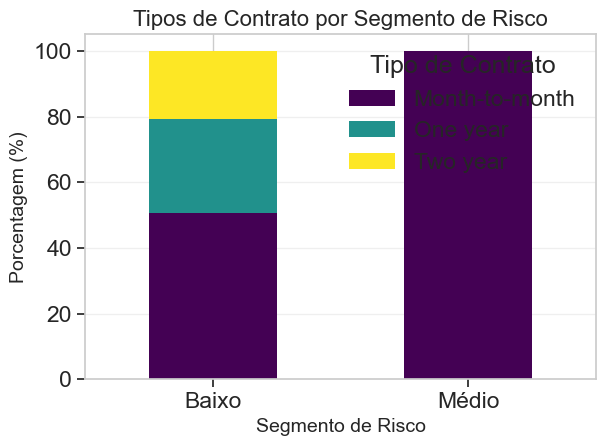

In [13]:
# 9.1. Aplicar modelo no conjunto completo
df_churn['churn_probability'] = best_clf.predict_proba(X)[:, 1]

# 9.2. Criar segmentos de risco
def classify_risk(prob):
    if prob < 0.3:
        return 'Baixo'
    elif prob < 0.6:
        return 'Médio'
    else:
        return 'Alto'

df_churn['risk_segment'] = df_churn['churn_probability'].apply(classify_risk)

# 9.3. Análise dos segmentos
risk_distribution = df_churn['risk_segment'].value_counts()
print("Distribuição dos segmentos de risco:")
print(risk_distribution)

# Visualização da distribuição de segmentos
plt.figure(figsize=(10, 8))
risk_distribution.plot(kind='bar', color=sns.color_palette('viridis', 3))
plt.title('Distribuição dos Segmentos de Risco', fontsize=16)
plt.xlabel('Segmento de Risco', fontsize=14)
plt.ylabel('Número de Clientes', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Adicionar rótulos de contagem
for i, v in enumerate(risk_distribution):
    plt.text(i, v + 50, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# 9.4. Análise de características por segmento de risco
segment_profiles = df_churn.groupby('risk_segment')[
    ['tenure', 'MonthlyCharges', 'TotalCharges']
].mean()

print("\nPerfil médio por segmento de risco:")
print(segment_profiles)

# 9.5. Contrato por segmento de risco
contract_by_risk = pd.crosstab(df_churn['risk_segment'], df_churn['Contract'], normalize='index') * 100
print("\nDistribuição de tipos de contrato por segmento de risco (%):\n")
print(contract_by_risk)

# Visualização
plt.figure(figsize=(12, 8))
contract_by_risk.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Tipos de Contrato por Segmento de Risco', fontsize=16)
plt.xlabel('Segmento de Risco', fontsize=14)
plt.ylabel('Porcentagem (%)', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Tipo de Contrato')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Conclusões e Recomendações Estratégicas

### 10.1. Principais Insights do Modelo

1. **Fatores de Maior Impacto no Churn**:
   - Contrato mensal (alto risco)
   - Tempo como cliente curto
   - Ausência de serviços de segurança online e suporte técnico
   - Pagamento via cheque eletrônico
   - Serviço de internet por fibra óptica sem serviços complementares

2. **Fatores de Retenção**:
   - Contratos de longo prazo (dois anos)
   - Maior tempo como cliente
   - Presença de dependentes
   - Serviços adicionais (especialmente segurança e backup)

### 10.2. Recomendações Estratégicas

1. **Para Clientes de Alto Risco**:
   - Programa de fidelização com incentivos para migração para contratos mais longos
   - Oferecer descontos em pacotes de serviços de segurança e suporte técnico
   - Implementar sistema de alerta precoce para clientes com alta probabilidade de churn
   - Equipe dedicada para retenção proativa desses clientes

2. **Para Clientes de Médio Risco**:
   - Campanhas segmentadas destacando o valor dos serviços complementares
   - Programas de pontos por longevidade como cliente
   - Promoções específicas para adoção de métodos de pagamento automáticos

3. **Para Clientes de Baixo Risco**:
   - Estratégias de venda cruzada (cross-selling) para aumentar o valor do cliente
   - Programas de recomendação e indicação com bônus
   - Reconhecimento da fidelidade com benefícios exclusivos

### 10.3. Próximos Passos

1. **Refinamento do Modelo**:
   - Inclusão de dados comportamentais (uso de serviços, padrões de chamadas)
   - Implementação de modelos de aprendizado profundo para detectar padrões mais complexos
   - Experimentação com técnicas de ensemble para melhorar a precisão

2. **Implementação Operacional**:
   - Integração do modelo ao CRM da empresa
   - Dashboards em tempo real para monitoramento de risco de churn
   - Sistema automatizado de alertas para clientes de alto risco

3. **Validação Contínua**:
   - Testes A/B de estratégias de retenção
   - Análise de custo-benefício das intervenções
   - Monitoramento do modelo para drift ao longo do tempo

Este modelo de regressão logística para previsão de churn fornece uma base sólida para implementar estratégias de retenção baseadas em dados, potencialmente economizando recursos significativos para a empresa ao priorizar esforços nos clientes com maior risco de cancelamento.